# **Spatial-Spectral Summarizer Fusion Network (S³F-Net)**

This notebook contains the full implementation of **S³F-Net** on the Chest X-ray Pneumonia dataset. We use the **SpectraNet-1** variant as the spectral encoder here, and use simple **Concatenation Fusion** to fuse the two branches (Spatial & Spectral). The full architecture is customizable, feel free to do so. Edit the file paths according to your setup.

## **Data Preparation**

In [ ]:
# ==============================================================================
# BLOCK 1: SETUP, IMPORTS AND DATA LOADING (FOR CHEST X-RAY)
# ==============================================================================
import os
import cv2
import zipfile
import numpy as np
import tensorflow as tf
from google.colab import drive
from tensorflow.keras import layers, models, optimizers, callbacks
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, cohen_kappa_score, matthews_corrcoef, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# --- Setup ---
print("--- Mounting Google Drive ---")
drive.mount('/content/drive')

# --- Configuration ---
# Aspect ratio for 1600x1200 (4:3) scaled to a width of 512
IMG_SIZE = (384, 512)
BATCH_SIZE = 16
EPOCHS = 100
RANDOM_STATE = 42

# --- Paths ---
ZIP_PATH = "/content/drive/MyDrive/Medical Image Segmentation/chest_xray.zip"
TEMP_DATA_DIR = "/content/chest_xray_temp"

# Unzipping the data
if not os.path.exists(TEMP_DATA_DIR):
    print(f"\n--- Unzipping dataset to local runtime... ---")
    with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
        zip_ref.extractall(TEMP_DATA_DIR)
    print("\n--- Unzipping complete! ---")
else:
    print("\n--- Dataset already unzipped. ---")

DATASET_BASE_PATH = os.path.join(TEMP_DATA_DIR, "chest_xray")
SAVE_FOLDER = "/content/drive/MyDrive/S3F_Net_Models"
os.makedirs(SAVE_FOLDER, exist_ok=True)

--- Mounting Google Drive ---
Mounted at /content/drive

--- Unzipping dataset to local runtime... ---

--- Unzipping complete! ---


In [ ]:
# ==============================================================================
# 2. Data Loading (Adapted for the Chest-XRay Dataset structure)
# ==============================================================================

def load_xray_split(folder_path):
    """Loads images and labels from a folder with NORMAL/PNEUMONIA subdirectories."""
    images, labels = [], []
    # Ensuring PNEUMONIA is consistently mapped to 1 (the positive class)
    class_names = ['NORMAL', 'PNEUMONIA']
    class_map = {name: i for i, name in enumerate(class_names)}
    print(f"Loading data from: {folder_path} with classes {class_map}")

    for class_name in class_names:
        class_path = os.path.join(folder_path, class_name)
        if not os.path.isdir(class_path): continue
        for filename in os.listdir(class_path):
            if not filename.lower().endswith(('.jpeg', '.jpg', '.png')): continue
            img_path = os.path.join(class_path, filename)
            try:
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img is None: continue
                img = cv2.resize(img, (IMG_SIZE[1], IMG_SIZE[0]), interpolation=cv2.INTER_AREA)
                img = img.astype('float32') / 255.0
                images.append(img[..., np.newaxis])
                labels.append(class_map[class_name])
            except Exception as e:
                print(f"Error loading {img_path}: {e}")

    indices = np.arange(len(images))
    np.random.shuffle(indices)
    return np.array(images)[indices], np.array(labels)[indices], class_names

try:
    TRAIN_PATH = os.path.join(DATASET_BASE_PATH, "train")
    TEST_PATH = os.path.join(DATASET_BASE_PATH, "test")

    X_train, y_train, CLASS_NAMES = load_xray_split(TRAIN_PATH)
    X_test, y_test, _ = load_xray_split(TEST_PATH)

    X_val, y_val = X_test, y_test

    print("\n--- Data Loading Summary ---")
    print(f"Training set:   {len(X_train)} samples")
    print(f"Validation/Test set: {len(X_val)} samples")

    #Computing Class Weights to address imbalance in data
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    class_weights_dict = dict(enumerate(class_weights))
    print(f"Calculated class weights: {class_weights_dict}")

except Exception as e:
    print(f"An error occurred during data loading: {e}"); exit()

Loading data from: /content/chest_xray_temp/chest_xray/train with classes {'NORMAL': 0, 'PNEUMONIA': 1}
Loading data from: /content/chest_xray_temp/chest_xray/test with classes {'NORMAL': 0, 'PNEUMONIA': 1}

--- Data Loading Summary ---
Training set:   5232 samples
Validation/Test set: 624 samples
Calculated class weights: {0: np.float64(1.939214232765011), 1: np.float64(0.6737058975019315)}


## **S³F-Net (Concatenation-Fusion SN1 Variant) Model Building**

In [ ]:
# ==============================================================================
# BLOCK 3: MODEL ARCHITECTURE (CONCATENATION FUSION FOR CHEST X-RAY)
# ==============================================================================
# This block defines the S³F-Net with SpectraNet-1 + Concatenation Fusion

# --- Custom SpectralFilter Layer & Encoders ---
class SpectralFilterLayer(layers.Layer):
    def __init__(self, filters, **kwargs): super().__init__(**kwargs); self.filters = filters
    def build(self, input_shape):
        _, h, w, c = input_shape
        fft_shape = (h, w // 2 + 1)
        self.real_weights = self.add_weight(name='real_weights', shape=(c, self.filters, *fft_shape), initializer='glorot_uniform')
        self.imag_weights = self.add_weight(name='imag_weights', shape=(c, self.filters, *fft_shape), initializer='glorot_uniform')
        self.bias = self.add_weight(name='bias', shape=(self.filters,), initializer='zeros')
    def call(self, inputs):
        inputs_p = tf.transpose(inputs, [0, 3, 1, 2])
        inputs_fft = tf.signal.rfft2d(inputs_p)
        kernel_fft = tf.complex(self.real_weights, self.imag_weights)
        output_fft = tf.einsum('bchw,cfhw->bfhw', inputs_fft, kernel_fft)
        output_s = tf.signal.irfft2d(output_fft)
        output_p = tf.transpose(output_s, [0, 2, 3, 1])
        return output_p + self.bias
    def get_config(self):
        config = super().get_config()
        config.update({"filters": self.filters})
        return config

def build_spatial_encoder(inputs):
    x = inputs
    x = layers.Conv2D(32, 3, padding='same', activation='relu')(x)
    x = layers.Conv2D(32, 3, padding='same')(x); x = layers.BatchNormalization()(x); x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    x = layers.Conv2D(64, 3, padding='same')(x); x = layers.BatchNormalization()(x); x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)
    x = layers.Conv2D(128, 3, padding='same')(x); x = layers.BatchNormalization()(x); x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Conv2D(256, 3, padding='same', activation='relu')(x)
    x = layers.Conv2D(256, 3, padding='same')(x); x = layers.BatchNormalization()(x); x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Dropout(0.4)(x)
    return x

def depthwise_sep_block(x, filters, kernel_size=3, strides=1):
    x = layers.DepthwiseConv2D(kernel_size, strides=strides, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(filters, 1, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    return x

def build_spectral_summary_branch(inputs):
    x = SpectralFilterLayer(32)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = depthwise_sep_block(x, 64)
    x = layers.MaxPooling2D(2)(x)

    x = depthwise_sep_block(x, 128)
    x = layers.MaxPooling2D(2)(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(16, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.1875)(x)
    x = layers.Dense(4, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3125)(x)

    return x

# --- S³F-Net Model Builder with Concatenation Fusion ---
def build_s3f_net_concatenation_binary(input_shape):
    """Builds the S³F-Net with Concatenation fusion for binary classification."""
    inputs = layers.Input(input_shape)

    # --- Tower 1: Deep Spatial Branch ---
    spatial_features = build_spatial_encoder(inputs)
    spatial_vector_raw = layers.GlobalAveragePooling2D()(spatial_features)
    spatial_refined = layers.Dense(512, activation='relu')(spatial_vector_raw)
    spatial_refined = layers.BatchNormalization()(spatial_refined)
    spatial_refined = layers.Dropout(0.5)(spatial_refined)

    # --- Tower 2: Spectral Summary Branch ---
    spectral_summary_vector = build_spectral_summary_branch(inputs)

    # --- Concatenation Fusion ---
    fused_vector = layers.concatenate([spatial_refined, spectral_summary_vector])

    # Output Layer
    outputs = layers.Dense(1, activation='sigmoid')(fused_vector)

    model = models.Model(inputs, outputs, name="S3F_Net_Concatenation_Binary")

    # Compiling with BCE loss
    model.compile(optimizer=optimizers.Adam(0.0003),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

print("Concatenation Fusion S³F-Net model architecture is ready for Chest X-Ray.")

Concatenation Fusion S3F-Net model architecture is ready for Chest X-Ray.


## **Model Training**

In [ ]:
# ===========================================
# BLOCK 4: CUSTOM CALLBACK AND TRAINING
# ===========================================

# --- Binary F1 Score Callback ---
class BinaryF1ScoreCallback(callbacks.Callback):
    def __init__(self, validation_data, filepath, patience=15):
        super(BinaryF1ScoreCallback, self).__init__()
        self.validation_data = validation_data
        self.filepath = filepath
        self.patience = patience
        self.best_f1 = -1.0
        self.wait = 0
    def on_epoch_end(self, epoch, logs=None):
        X_val, y_val = self.validation_data
        y_pred_proba = self.model.predict(X_val, verbose=0)
        y_pred = (y_pred_proba > 0.5).astype(int)
        f1 = f1_score(y_val, y_pred, pos_label=1, zero_division=0)
        logs['val_f1'] = f1
        print(f" - val_f1 (PNEUMONIA): {f1:.4f}", end="")
        if f1 > self.best_f1:
            print(f" (New best F1, saving model)")
            self.best_f1 = f1
            self.model.save(self.filepath)
            self.wait = 0
        else:
            print()
            self.wait += 1
            if self.wait >= self.patience:
                print("Early stopping.")
                self.model.stop_training = True

# --- Training ---
CLASSIFIER_MODEL_PATH = os.path.join(SAVE_FOLDER, "Concatenation_S3f_net_SN1_XRAY.keras")
print("\n--- Building Concatenation Fusion S³F-Net for Chest X-Ray ---")
classifier_model_concat = build_s3f_net_concatenation_binary(X_train.shape[1:])
classifier_model_concat.summary()

f1_callback_concat = BinaryF1ScoreCallback(validation_data=(X_val, y_val), filepath=CLASSIFIER_MODEL_PATH, patience=20)
reduce_lr_concat = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=1e-6)

history_concat = classifier_model_concat.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    class_weight=class_weights_dict,
    callbacks=[f1_callback_concat, reduce_lr_concat]
)

print("\n--- Training Finished ---")


--- Building Concatenation Fusion S3F-Net for Chest X-Ray ---


Model: "S3F_Net_Concatenation_Binary"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 384, 512,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_30 (Conv2D)  │ (None, 384, 512,  │        320 │ input_layer_4[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_31 (Conv2D)  │ (None, 384, 512,  │      9,248 │ conv2d_30[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 384, 512,  │        128 │ conv2d_31[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_12       │ (None, 384, 512,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_19    │ (None, 192, 256,  │          0 │ activation_12[0]… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spectral_conv_laye… │ (None, 384, 512,  │  6,316,064 │ input_layer_4[0]… │
│ (SpectralConvLayer) │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_23          │ (None, 192, 256,  │          0 │ max_pooling2d_19… │
│ (Dropout)           │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 384, 512,  │        128 │ spectral_conv_la… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_32 (Conv2D)  │ (None, 192, 256,  │     18,496 │ dropout_23[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_18 (ReLU)     │ (None, 384, 512,  │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_33 (Conv2D)  │ (None, 192, 256,  │     36,928 │ conv2d_32[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ depthwise_conv2d_6  │ (None, 384, 512,  │        288 │ re_lu_18[0][0]    │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 192, 256,  │        256 │ conv2d_33[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 384, 512,  │        128 │ depthwise_conv2d… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_13       │ (None, 192, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_19 (ReLU)     │ (None, 384, 512,  │          0 │ batch_normalizat

 Total params: 7,638,409 (29.14 MB)

 Trainable params: 7,635,745 (29.13 MB)

 Non-trainable params: 2,664 (10.41 KB)

Epoch 1/100
327/327 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.7284 - loss: 0.5146 - val_f1 (PNEUMONIA): 0.7692 (New best F1, saving model)
327/327 ━━━━━━━━━━━━━━━━━━━━ 62s 122ms/step - accuracy: 0.7286 - loss: 0.5143 - val_accuracy: 0.6250 - val_loss: 1.5595 - val_f1: 0.7692 - learning_rate: 3.0000e-04
Epoch 2/100
327/327 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.8875 - loss: 0.2816 - val_f1 (PNEUMONIA): 0.7746 (New best F1, saving model)
327/327 ━━━━━━━━━━━━━━━━━━━━ 32s 99ms/step - accuracy: 0.8875 - loss: 0.2816 - val_accuracy: 0.6362 - val_loss: 1.4833 - val_f1: 0.7746 - learning_rate: 3.0000e-04
Epoch 3/100
327/327 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.9122 - loss: 0.2088 - val_f1 (PNEUMONIA): 0.6056
327/327 ━━━━━━━━━━━━━━━━━━━━ 32s 97ms/step - accuracy: 0.9123 - loss: 0.2088 - val_accuracy: 0.6410 - val_loss: 1.0361 - val_f1: 0.6056 - learning_rate: 3.0000e-04
Epoch 4/100
327/327 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.9365 - loss: 0.1575 - val_f1 (PN

## **Evaluation**



--- Final Evaluation on Chest X-Ray Test Set ---
Loading best model from: /content/drive/MyDrive/S2F_Net_Models/Concatenation_S3f_net_SN1_XRAY.keras

Test Loss: 0.1743
Test Accuracy: 0.9391
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 160ms/step

--- Detailed Performance Metrics ---
F1 Score (Pneumonia): 0.9515
Cohen's Kappa: 0.8696
MCC: 0.8697
AUC-ROC: 0.9821

--- Classification Report ---
              precision    recall  f1-score   support

      NORMAL     0.9261    0.9103    0.9181       234
   PNEUMONIA     0.9467    0.9564    0.9515       390

    accuracy                         0.9391       624
   macro avg     0.9364    0.9333    0.9348       624
weighted avg     0.9390    0.9391    0.9390       624


--- Confusion Matrix ---


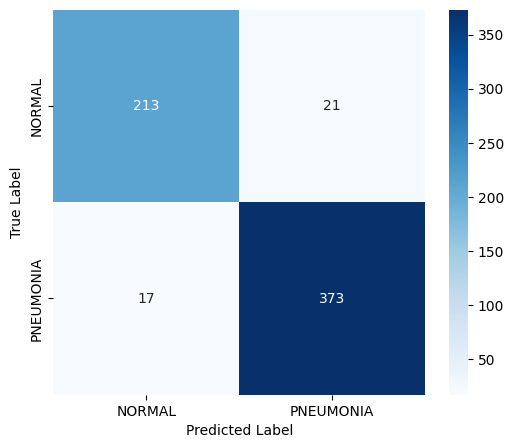


--- ROC Curve Analysis ---


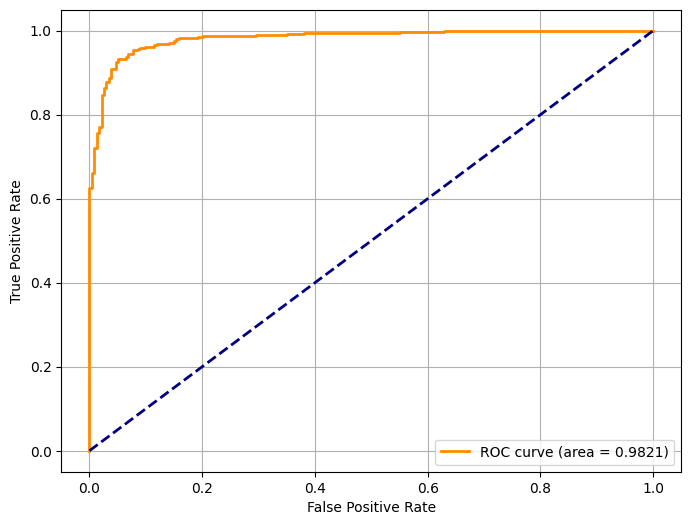

In [ ]:
# ======================
# BLOCK 5: EVALUATION
# ======================
print("\n\n--- Final Evaluation on Chest X-Ray Test Set ---")
CLASSIFIER_MODEL_PATH = os.path.join(SAVE_FOLDER, "Concatenation_S3f_net_SN1_XRAY.keras")
custom_objects = {'SpectralFilterLayer': SpectralFilterLayer}
try:
    print(f"Loading best model from: {CLASSIFIER_MODEL_PATH}")
    best_model = models.load_model(CLASSIFIER_MODEL_PATH, custom_objects=custom_objects)

    loss, accuracy = best_model.evaluate(X_test, y_test, verbose=0)
    print(f"\nTest Loss: {loss:.4f}"); print(f"Test Accuracy: {accuracy:.4f}")

    y_pred_proba = best_model.predict(X_test)
    y_pred_classes = (y_pred_proba > 0.5).astype(int)

    print("\n--- Detailed Performance Metrics ---")
    f1_pneumonia = f1_score(y_test, y_pred_classes, pos_label=1)
    print(f"F1 Score (Pneumonia): {f1_pneumonia:.4f}")
    print(f"Cohen's Kappa: {cohen_kappa_score(y_test, y_pred_classes):.4f}")
    print(f"MCC: {matthews_corrcoef(y_test, y_pred_classes):.4f}")
    print(f"AUC-ROC: {roc_auc_score(y_test, y_pred_proba):.4f}")

    print("\n--- Classification Report ---")
    print(classification_report(y_test, y_pred_classes, target_names=CLASS_NAMES, digits=4))

    print("\n--- Confusion Matrix ---")
    cm = confusion_matrix(y_test, y_pred_classes)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    # plt.title('S³F-Net on Chest X-Ray (Test Set)')
    plt.show()

    if 'history' in locals():
        print("\n--- Training History Plots ---")
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
        ax1.plot(history_concat.history['loss'], label='Train Loss')
        ax1.plot(history_concat.history['val_loss'], label='Val Loss')
        # ax1.set_title('Model Loss')
        ax1.legend()
        ax1.grid(True)
        ax2.plot(history_concat.history['accuracy'], label='Train Accuracy')
        ax2.plot(history_concat.history['val_accuracy'], label='Val Accuracy')
        if 'val_f1' in history_concat.history:
            ax2.plot(history_concat.history['val_f1'], label='Validation F1', linestyle='--')
        # ax2.set_title('Model Performance')
        ax2.legend()
        ax2.grid(True)
        plt.show()

    print("\n--- ROC Curve Analysis ---")
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--');
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

except Exception as e:
    print(f"An error occurred during evaluation: {e}")